In [1]:
%load_ext autoreload
%autoreload 2

In [85]:
import sys
import time
import rebound
import matplotlib.pyplot as plt
import numpy as np
import vanillaWH
import vanillaWH_tools

%matplotlib inline

# configuring plots
#plt.rc('text', usetex=True)             # use LaTeX for text
plt.rc('font', family='serif')          # use serif font
plt.rcParams.update({'font.size': 14})  # increase font size

In [106]:
# initial conditions from outer Solar system: Sun, Jupiter, Saturn, Uranus, Neptune, Pluto
# could also late test w/ restricted 3-body problem: https://w.astro.berkeley.edu/~echiang/classmech/final.pdf

SS = rebound.Simulation()
rebound.data.add_outer_solar_system(SS)

# particle array as [x, y, z, vx, vy, vz, m]
p0 = np.array([SS.particles[0].x,SS.particles[0].y,SS.particles[0].z,SS.particles[0].vx,SS.particles[0].vy,SS.particles[0].vz,SS.particles[0].m])
p1 = np.array([SS.particles[1].x,SS.particles[1].y,SS.particles[1].z,SS.particles[1].vx,SS.particles[1].vy,SS.particles[1].vz,SS.particles[1].m])
p2 = np.array([SS.particles[2].x,SS.particles[2].y,SS.particles[2].z,SS.particles[2].vx,SS.particles[2].vy,SS.particles[2].vz,SS.particles[2].m])
p3 = np.array([SS.particles[3].x,SS.particles[3].y,SS.particles[3].z,SS.particles[3].vx,SS.particles[3].vy,SS.particles[3].vz,SS.particles[3].m])
p4 = np.array([SS.particles[4].x,SS.particles[4].y,SS.particles[4].z,SS.particles[4].vx,SS.particles[4].vy,SS.particles[4].vz,SS.particles[4].m])
p5 = np.array([SS.particles[5].x,SS.particles[5].y,SS.particles[5].z,SS.particles[5].vx,SS.particles[5].vy,SS.particles[5].vz,SS.particles[5].m])
sim = np.stack([p0, p1, p2, p3, p4, p5])

sim = vanillaWH_tools.move_to_com(sim)

timestep = 0.1
N_steps = 10000

energy_error = np.zeros(N_steps)
E0 = vanillaWH_tools.energy_fn(sim)

orbit_soln = np.zeros((len(sim), 3, N_steps)) # [object, position, N_steps]
orbit_soln[:,0,0], orbit_soln[:,1,0], orbit_soln[:,2,0] = sim[:,0], sim[:,1], sim[:,2]

start = time.time()

simj = vanillaWH_tools.inertial_to_jacobi(sim)

for i in range(N_steps):
    
    # drift
    simj = vanillaWH.drift(simj, sim, object_num = 1, h=timestep/2)
    simj = vanillaWH.drift(simj, sim, object_num = 2, h=timestep/2)
    simj = vanillaWH.drift(simj, sim, object_num = 3, h=timestep/2)
    simj = vanillaWH.drift(simj, sim, object_num = 4, h=timestep/2)
    simj = vanillaWH.drift(simj, sim, object_num = 5, h=timestep/2)
    sim = vanillaWH_tools.jacobi_to_inertial(simj, sim)
    
    # kick
    simj = vanillaWH.kick(simj, sim, h=timestep)
    
    # drift
    simj = vanillaWH.drift(simj, sim, object_num = 1, h=timestep/2)
    simj = vanillaWH.drift(simj, sim, object_num = 2, h=timestep/2)
    simj = vanillaWH.drift(simj, sim, object_num = 3, h=timestep/2)
    simj = vanillaWH.drift(simj, sim, object_num = 4, h=timestep/2)
    simj = vanillaWH.drift(simj, sim, object_num = 5, h=timestep/2)
    sim = vanillaWH_tools.jacobi_to_inertial(simj, sim)

    E = vanillaWH_tools.energy_fn(sim)
    energy_error[i] = np.abs((E-E0)/E0)

    orbit_soln[:, 0, i] = sim[:,0]
    orbit_soln[:, 1, i] = sim[:,1]
    orbit_soln[:, 2, i] = sim[:,2]

end = time.time()

print('time to integrate =', np.round(end - start, 1), 's')

time to integrate = 13.0 s


In [107]:
SS.integrator='whfast'
SS.dt = timestep
SS.move_to_com()

energy_error_reb = np.zeros(N_steps) 
E0 = SS.calculate_energy()

orbit_soln_rebound = np.zeros((len(sim), 3, N_steps))
diff0, diff1, diff2 = np.zeros(N_steps), np.zeros(N_steps), np.zeros(N_steps)
diff3, diff4, diff5 = np.zeros(N_steps), np.zeros(N_steps), np.zeros(N_steps)

for i in range(N_steps):
    SS.step() 
    
    E = SS.calculate_energy()
    energy_error_reb[i] = np.abs((E-E0)/E0)
    
    orbit_soln_rebound[0,:,i] = SS.particles[0].x, SS.particles[0].y, SS.particles[0].z
    orbit_soln_rebound[1,:,i] = SS.particles[1].x, SS.particles[1].y, SS.particles[1].z
    orbit_soln_rebound[2,:,i] = SS.particles[2].x, SS.particles[2].y, SS.particles[2].z
    orbit_soln_rebound[3,:,i] = SS.particles[3].x, SS.particles[3].y, SS.particles[3].z
    orbit_soln_rebound[4,:,i] = SS.particles[4].x, SS.particles[4].y, SS.particles[4].z
    orbit_soln_rebound[5,:,i] = SS.particles[5].x, SS.particles[5].y, SS.particles[5].z
    
    dx0 = orbit_soln_rebound[0,0,i]-orbit_soln[0,0,i]
    dy0 = orbit_soln_rebound[0,1,i]-orbit_soln[0,1,i]
    dz0 = orbit_soln_rebound[0,2,i]-orbit_soln[0,2,i]
    diff0[i] = np.sqrt(dx0**2 + dy0**2 + dz0**2)
    
    dx1 = orbit_soln_rebound[1,0,i]-orbit_soln[1,0,i]
    dy1 = orbit_soln_rebound[1,1,i]-orbit_soln[1,1,i]
    dz1 = orbit_soln_rebound[1,2,i]-orbit_soln[1,2,i]
    diff1[i] = np.sqrt(dx1**2 + dy1**2 + dz1**2)
    
    dx2 = orbit_soln_rebound[2,0,i]-orbit_soln[2,0,i]
    dy2 = orbit_soln_rebound[2,1,i]-orbit_soln[2,1,i]
    dz2 = orbit_soln_rebound[2,2,i]-orbit_soln[2,2,i]
    diff2[i] = np.sqrt(dx2**2 + dy2**2 + dz2**2)
    
    dx3 = orbit_soln_rebound[3,0,i]-orbit_soln[3,0,i]
    dy3 = orbit_soln_rebound[3,1,i]-orbit_soln[3,1,i]
    dz3 = orbit_soln_rebound[3,2,i]-orbit_soln[3,2,i]
    diff3[i] = np.sqrt(dx3**2 + dy3**2 + dz3**2)
    
    dx4 = orbit_soln_rebound[4,0,i]-orbit_soln[4,0,i]
    dy4 = orbit_soln_rebound[4,1,i]-orbit_soln[4,1,i]
    dz4 = orbit_soln_rebound[4,2,i]-orbit_soln[4,2,i]
    diff4[i] = np.sqrt(dx4**2 + dy4**2 + dz4**2)
    
    dx5 = orbit_soln_rebound[5,0,i]-orbit_soln[5,0,i]
    dy5 = orbit_soln_rebound[5,1,i]-orbit_soln[5,1,i]
    dz5 = orbit_soln_rebound[5,2,i]-orbit_soln[5,2,i]
    diff5[i] = np.sqrt(dx5**2 + dy5**2 + dz5**2)


Integrate with timestep = 0.1 for 10000 steps = 159.13902759758616 years.


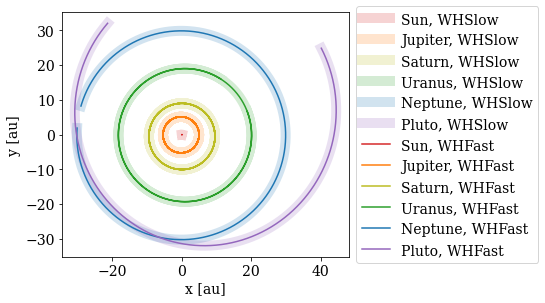

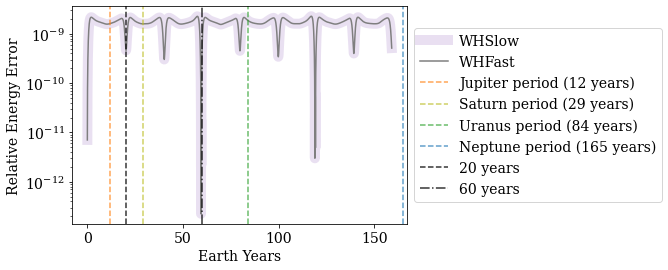

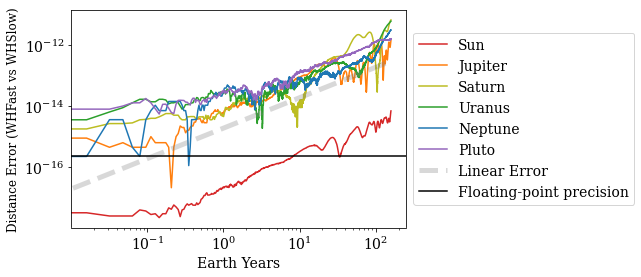

In [129]:
years = timestep * np.arange(N_steps) / (2*np.pi)
print('Integrate with timestep =', timestep, 'for', N_steps, 'steps =', years[-1], 'years.')

plt.figure(figsize=(10,4.5))
plt.plot(orbit_soln[0,0], orbit_soln[0,1], lw=10, alpha=0.2, label='Sun, WHSlow', c='tab:red')
plt.plot(orbit_soln[1,0], orbit_soln[1,1], lw=10, alpha=0.2, label='Jupiter, WHSlow', c='tab:orange')
plt.plot(orbit_soln[2,0], orbit_soln[2,1], lw=10, alpha=0.2, label='Saturn, WHSlow', c='tab:olive')
plt.plot(orbit_soln[3,0], orbit_soln[3,1], lw=10, alpha=0.2, label='Uranus, WHSlow', c='tab:green')
plt.plot(orbit_soln[4,0], orbit_soln[4,1], lw=10, alpha=0.2, label='Neptune, WHSlow', c='tab:blue')
plt.plot(orbit_soln[5,0], orbit_soln[5,1], lw=10, alpha=0.2, label='Pluto, WHSlow', c='tab:purple')
plt.plot(orbit_soln_rebound[0,0], orbit_soln_rebound[0,1], label='Sun, WHFast', c='tab:red')
plt.plot(orbit_soln_rebound[1,0], orbit_soln_rebound[1,1], label='Jupiter, WHFast', c='tab:orange')
plt.plot(orbit_soln_rebound[2,0], orbit_soln_rebound[2,1], label='Saturn, WHFast', c='tab:olive')
plt.plot(orbit_soln_rebound[3,0], orbit_soln_rebound[3,1], label='Uranus, WHFast', c='tab:green')
plt.plot(orbit_soln_rebound[4,0], orbit_soln_rebound[4,1], label='Neptune, WHFast', c='tab:blue')
plt.plot(orbit_soln_rebound[5,0], orbit_soln_rebound[5,1], label='Pluto, WHFast', c='tab:purple')
plt.axis('scaled')
plt.xlabel('x [au]')
plt.ylabel('y [au]')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.plot(years, energy_error, lw=10, alpha=0.2, label='WHSlow', c='tab:purple')
plt.plot(years, energy_error_reb, label='WHFast', c='tab:gray')
plt.axvline(12, ls='--', alpha=0.7, label='Jupiter period (12 years)', c='tab:orange')
plt.axvline(29, ls='--', alpha=0.7, label='Saturn period (29 years)', c='tab:olive')
plt.axvline(84, ls='--', alpha=0.7, label='Uranus period (84 years)', c='tab:green')
plt.axvline(165, ls='--', alpha=0.7, label='Neptune period (165 years)', c='tab:blue')
plt.axvline(20, ls='--', alpha=0.8, label='20 years', c='black')
plt.axvline(60, ls='-.', alpha=0.8, label='60 years', c='black')
#plt.axvline(20, ls='--', label='Uranus - Saturn period', c='black')
plt.yscale('log')
plt.xlabel('Earth Years')
plt.ylabel('Relative Energy Error')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.plot(years, diff0, label='Sun', c='tab:red')
plt.plot(years, diff1, label='Jupiter', c='tab:orange')
plt.plot(years, diff2, label='Saturn', c='tab:olive')
plt.plot(years, diff3, label='Uranus', c='tab:green')
plt.plot(years, diff4, label='Neptune', c='tab:blue')
plt.plot(years, diff5, label='Pluto', c='tab:purple')
plt.plot(years, 3e-17*np.arange(N_steps),ls = '--', c='grey', lw=5, alpha=0.3, label='Linear Error')
plt.axhline(sys.float_info.epsilon, label='Floating-point precision', c='black')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Earth Years')
plt.ylabel('Distance Error (WHFast vs WHSlow)', fontsize=12)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [89]:
# particle array as [rx, ry, vx, vy, m]
p0 = np.array([0., 0., 0., 0., 0., 0., 1.])
p1 = np.array([1., 0., 0., 0., 1., 0., 1e-3])
p2 = np.array([2., 0., 0., 0., 0.7, 0., 1e-3])
sim = np.stack([p0, p1, p2])

sim = vanillaWH_tools.move_to_com(sim)

print('sim before transform', sim[:,:5])

simj = vanillaWH_tools.inertial_to_jacobi(sim)

print('simj after transform', simj[:,:5])

sim = vanillaWH_tools.jacobi_to_inertial(simj, sim)

print('sim after transform back', sim[:,:5])

sim before transform [[-2.99401198e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -1.69660679e-03]
 [ 9.97005988e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   9.98303393e-01]
 [ 1.99700599e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   6.98303393e-01]]
simj after transform [[-4.32815239e-19  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -4.32815239e-19]
 [ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00]
 [ 1.99900100e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   6.99000999e-01]]
sim after transform back [[-2.99401198e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -1.69660679e-03]
 [ 9.97005988e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   9.98303393e-01]
 [ 1.99700599e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   6.98303393e-01]]
